<a href="https://colab.research.google.com/github/Rasamps/drug-misuse/blob/master/dim_reduction_ent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script calculates the Shannon Entropy of each column.
We can then select the ones with the least information as attributes which can be dropped.
This should support results obtained from the random forest dimensionality reduction experiment.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("drug_cons_data.csv", header = 0)


In [0]:
from math import e,log

def s_entropy(labels, base = None):
  """ Computes entropy of label distribution. """
  tot_labels = len(labels) #Gets the number of samples we have in our "distribution".
  #Check to ensure the passed column is not empty. 
  if (tot_labels <= 1):
    return 0
  #Get the unique labels of the passed column and the number of each label.
  value, counts = np.unique(labels, return_counts = True)
  #Compute the probability for each label.
  probs = counts / tot_labels
  n_classes = np.count_nonzero(probs)
  #Get the number of non-zero classes. Classes with probability zero will result in NaN calculations.
  if (n_classes <= 1):
    return 0
  #Initialize an entropy variable.
  ent = 0.0

  #Compute the entropy
  #Assign the base variable
  base = e if base is None else base
  for prob in probs:
    ent -= prob * log(prob, base)

  return ent

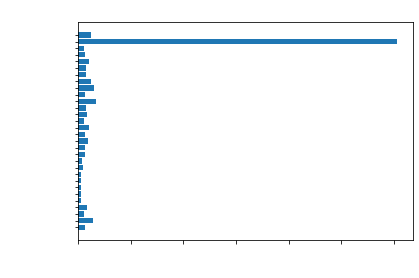

In [40]:
#Compute the Shannon Entropy for all column attributes. (Information is inverse)
attributes = df.columns
ent_results = []
for att in attributes:
  ent_results.append(s_entropy(df[[att]]))
inf_results = np.ones(len(ent_results))/ent_results

plt.title('Approx Inforamtion per Attribute', color = 'w')
plt.barh(df.columns, inf_results, align = 'center')
plt.yticks(color = 'w')
plt.ylabel('Attributes', color = 'w')
plt.xticks(color = 'w')
plt.xlabel('Approx Information', color = 'w')
#Displays the resulting plot.
plt.show()

Not sure if the calculation is appropriate...?
May not be something we want to base attribute selection on.

In [0]:
#Another option is using a chi squared test. We can randomly sample the attributes as targets
#and average the frequency of the results.

from sklearn.feature_selection import SelectKBest, chi2

def rand_chi2(trainset, target):
  reduced_feats = SelectKBest(chi2, k = 5).fit_transform(trainset,target) #A numpy array
  index_res = []
  trainset = trainset.to_numpy()
  for i in range(0,5):
    for j in range(0,22):
      if (np.array_equal(reduced_feats[:,i],trainset[:,j]) == True):
        index_res.append(j)
  return index_res

In [0]:
#Encode the catgorical features
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

for col in df.columns:
  if (df[col].dtype == np.object):
    df[col] = le.fit_transform(df[col])

df = df.drop(['Nscore','Ascore','Cscore','Oscore','Escore','Imp','SS'], axis = 1)

In [0]:
#Randomly sample ln(32) + 1 times to see what features are returned via the chi2 test.
#ln(32) + 1 is an utterly random number.
iters = int(np.ceil(np.log(32)) + 1)
results = np.empty([5,5])

for i in range(0,iters):
  curr_target = df.sample(1,axis = 1)
  temp_train = df.drop([curr_target.columns[0]], axis = 1)
  temp = rand_chi2(temp_train,curr_target)
  results[i,:] = temp

In [44]:
att_results = np.empty([5,5],dtype=np.object)
for i in range(0,5):
  for j in range(0,5):
    att_results[i,j] = df.iloc[:,int(results[i,j])].name

print(att_results)

[['Amph' 'Cann' 'Coke' 'Ect' 'Legalh']
 ['Amph' 'Benz' 'Coke' 'Ect' 'LSD']
 ['Caff' 'Crack' 'Keta' 'Legalh' 'Meth']
 ['Amph' 'Crack' 'Heroin' 'Legalh' 'Meth']
 ['Age' 'Caff' 'Keta' 'Legalh' 'Meth']]
